In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(10.5,19.5,90)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/5.52007811028631, 4*h/8.65372791291101]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=350)
    plt.show()

running for N =  40 with 2 processors


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocess

KeyboardInterrupt: 

Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216,

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


time taken 8739.30978679657 sec


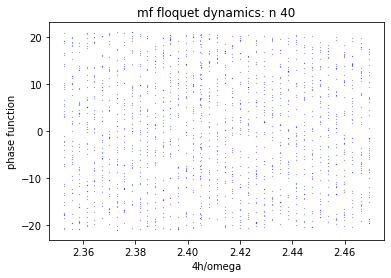

In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(40.5,42.5,40)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/2.4048255576957]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel1.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=400)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-1-d0f6403f3ee5>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 1831.0650618076324 sec


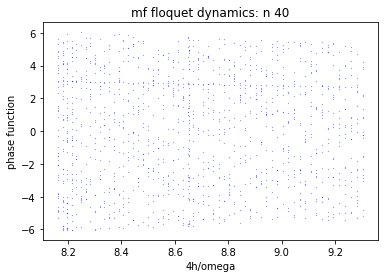

In [1]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(10.75,12.25,60)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/8.65372791291101]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=400)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-3-4fd27bbf07e7>:84: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 1503.7971024513245 sec


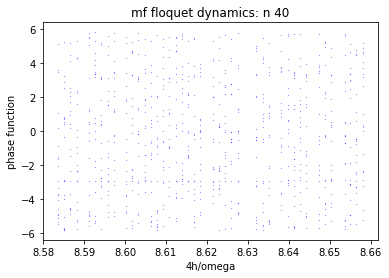

In [3]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(11.55,11.65,50)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
bessel = [4*h/8.65372791291101]
omegas = np.hstack((omega_range,bessel))
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3a.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=400)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-9-f45d17c3b6e4>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 449.29870676994324 sec


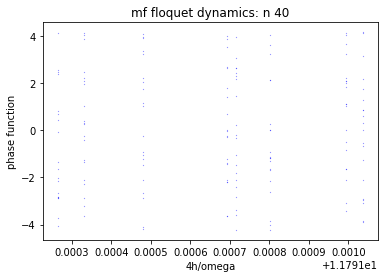

In [9]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(8.4803,8.4809,40)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
#bessel = [4*h/11.7915344390142]
#omegas = np.hstack((omega_range,bessel))
omegas = np.linspace(8.4803,8.4809,40)
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel4_check_delete_anytime.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='blue', marker='.', s= 0.1)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=500)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-2-2200a58da02d>:85: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))

time taken 6499.9444036483765 sec


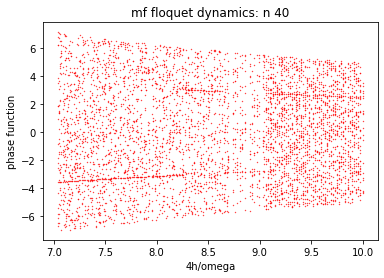

In [2]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 40
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
#omega_range = np.linspace(10.0,14.2,200)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
#bessel = [4*h/5.52007811028631, 4*h/8.65372791291101]
#omegas = np.hstack((omega_range,bessel))
omegas = np.linspace(10.0,14.2,200)
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3b.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='red', marker='.', s= 0.5)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.savefig(photoname, dpi=500)
    plt.show()

running for N =  40 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-20-dd7393a3cfff>:73: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals))/T
<ipython-input-20-dd7393a3cfff>:73: RuntimeWarning: invalid value encountered in multiply
  phasefunc = (1j * np.log(evals))/T
<ipython-input-20-dd7393a3cfff>:73: RuntimeWarning: invalid value encountered in true_divide
  phasefunc = (1j * np.log(evals))/T
<ipython-input-20-dd7393a3cfff>:73: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(eva

time taken 1140.3343229293823 sec


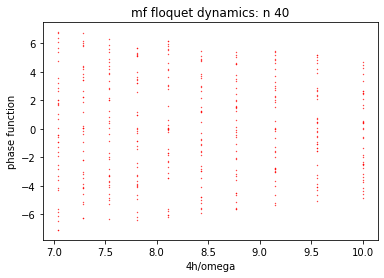

In [20]:
# lambda map functon introduction

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

N = 40
q = np.linspace(-0.5, 0.5, N)
h = 25.0
h0 = 0.1

omegas = np.linspace(10.0,14.2,10)
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
hotoname = "n_" + str(N) + "_mfd_bessel3b.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_func(periodic_psi,t,h,h0,w,cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return np.dot(jac, periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w                                            # time periode
    t = np.linspace(0,2 * np.pi/w,N)                           # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    psi_t = np.array(list(map(lambda psi0: odeintw(floq_func,psi0,t,args=(h,h0,w,cosp)), periodic_psi)))
    floqEvolution_mat = psi_t[:,N-1]
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)
    cosp_init = 0.0    
   
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
      
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    print("time taken", time.time()-start,"sec")
    
    for xx, omg in enumerate(omegas):
        #omega = [omg] * N
        omega = [4*h/omg] * N
        plt.scatter(omega, data[xx].real, color='red', marker='.', s= 0.5)
    plt.title(title)    
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    #plt.savefig(photoname, dpi=500)
    plt.show()

running for N =  8 with 2 processors


/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


time taken 106.12497878074646 sec


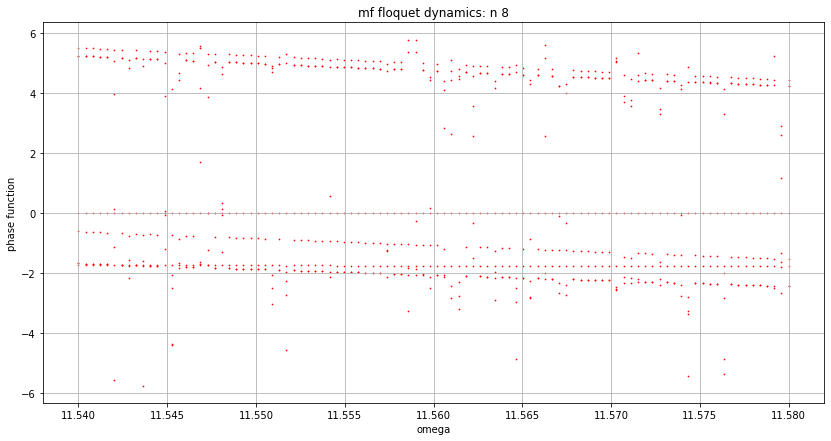

In [5]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time

start = time.time()

cosp_init = 0.0    
N = 8
h = 25.0
h0 = 0.1
    
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(11.54,11.58,100)
#omega2 = np.linspace(8.39,8.52,13)
#omega3 = np.linspace(11.5,11.6,30)
#omega4 = np.linspace(18.07,18.2,15)
#bessel = [4*h/2.4048255576957, 4*h/5.52007811028631,\
#              4*h/8.65372791291101, 4*h/11.7915344390142, 4*h/14.9309177084877]
#bessel = [4*h/5.52007811028631, 4*h/8.65372791291101]
#omegas = np.hstack((omega_range,omega3))
omegas = omega_range
psi = np.eye(N) + (1j) * np.zeros((N,N))

cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))

title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel3b.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

def floq_evolv(periodic_psi,h,h0,w,cosp):
    T = 2 * np.pi/w     # time periode
    t = np.linspace(0,2 * np.pi/w,N)      # time range
    floqEvoluion_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvoluion_mat[mm] = psi_t[N-1]
    
    evals, evecs = eig(floqEvoluion_mat)
    phasefunc = (1j * np.log(evals))/T
    return phasefunc
    
if __name__ == '__main__':
    nprocs = 2
    p = Pool(processes = nprocs)  
    print("running for N = ", N, "with",nprocs,"processors")
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
            
    data = p.starmap(floq_evolv,[(periodic_psi,h,h0,w,cosp) for w in omegas])
    
    print("time taken",time.time()-start,"sec")
    plt.figure(figsize=(14,7))
    
    for xx, omg in enumerate(omegas):
        omega = [omg] * N
        #omega = [4*h/omg] * N
        plt.scatter(omega,data[xx].real, color='red', marker='o', s= 0.5)
    plt.title(title)    
    #plt.xlabel("4h/omega")
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.grid()
    #plt.savefig(photoname, dpi=500)
    plt.show()

In [3]:
def binomialCoeff(n, k):
    result = 1
    for i in range(1, k+1):
        result = result * (n-i+1) / i
    return result

print(binomialCoeff(5,3))

10.0


### evolve only chosen wavefunctions 

<ipython-input-7-ea0323fb072d>:103: ComplexWarning: Casting complex values to real discards the imaginary part
  phasefunc_path[0] = phasefunc
<ipython-input-7-ea0323fb072d>:128: ComplexWarning: Casting complex values to real discards the imaginary part
  phasefunc_path[cc+1] = phasefunc


phaefunction path [-5.87519129e-16  9.40130556e-16 -5.87644066e-16 -1.17541307e-16
 -1.41064561e-15  1.17566295e-16  7.05472730e-16  1.17591282e-16
  3.52811327e-16  1.52901150e-15 -3.52886290e-16  1.17641257e-16
  2.35307502e-16 -1.17666245e-15 -5.88393692e-16 -1.17691232e-16
  7.06222355e-16  9.41729757e-16  9.41829707e-16 -8.24188450e-16
  8.24275907e-16  1.05989575e-15 -1.53112295e-15  2.35582364e-16
  8.24625732e-16  7.06897019e-16  3.53485991e-16 -1.17841157e-16
 -3.53560953e-16  1.06079530e-15  3.53635916e-16 -0.00000000e+00
  4.71614504e-16 -5.89580599e-16  9.43428909e-16  1.17941107e-16
 -2.35907202e-16  2.35932190e-16  1.65170024e-15 -1.17991082e-16
 -5.90017881e-16 -2.95040175e-16  1.18028564e-16 -4.72164230e-16
  7.67348083e-16 -1.77099067e-16 -5.90392694e-16  4.72364130e-16
  4.13362342e-16 -4.13406070e-16  6.49706826e-16  1.18141008e-16
 -4.72614005e-16 -0.00000000e+00 -7.09070933e-16 -1.35919630e-15
 -1.18203476e-16  8.27511791e-16  1.06405618e-15  1.59625293e-15
 -5.912

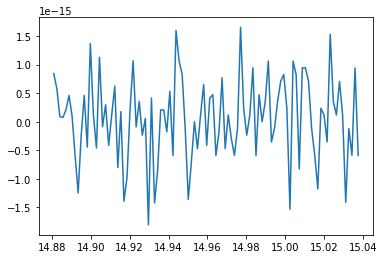

time taken 38.72493505477905


In [7]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time
from array import *

start = time.time()

cosp_init = 0.0    
N = 4
h = 25.0
h0 = 0.1
nn = 0   # this is the th column of the inital floquet evolution matrix 
         # for which the path we shall follow

q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(6.65,6.72,100)
omegas = omega_range


psi = np.eye(N) + (1j) * np.zeros((N,N))
cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(omegas))
prob = np.zeros(N)
title = "mf floquet dynamics path mode: n " + str(N) + "_bessel_5th_root"
photoname = "n_" + str(N) + "_mfd_bessel_path_bessel5.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)



if __name__ == '__main__':
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
    
    # calculate for first frequency
    w = omegas[0]
    T = 2 * np.pi/w                            
    t = np.linspace(0,2 * np.pi/w,N)           
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[N-1]
    
    #print('flomat',floqEvolution_mat)
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals[nn]))/T
    evecs_path = evecs[nn]/np.linalg.norm(evecs[nn])    # normalisation done
    phasefunc_path[0] = phasefunc
    
    # calculate for rest of the frequencies
    for cc, w in enumerate(omegas[1:len(omegas)]):
        T = 2 * np.pi/w                      
        t = np.linspace(0,2 * np.pi/w,N)    
        floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))        
        
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]       
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1] 
        evals, evecs = eig(floqEvolution_mat)
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs))) 
        #print('prob',prob)
        
        for i,pr in enumerate(prob):
            if (pr.real >= 0.99):
                pp = i
                #print('pp',pp)
                break
        evecs_path = evecs[pp]
        #print('evecs path',evecs_path)
        #print('evals[pp]',evals[pp])
        phasefunc = (1j * np.log(evals[pp]))/T
        phasefunc_path[cc+1] = phasefunc
    
    print('phaefunction path',phasefunc_path)
    plt.figure(figsize = (15,7))
    plt.title(title)
    
    plt.plot((4*h/omegas),phasefunc_path.real)
    plt.show()
    print('time taken',time.time()-start)

### lets do it for other frequencies

<ipython-input-63-ba6a404027d9>:103: ComplexWarning: Casting complex values to real discards the imaginary part
  phasefunc_path[0] = phasefunc
<ipython-input-63-ba6a404027d9>:128: ComplexWarning: Casting complex values to real discards the imaginary part
  phasefunc_path[cc+1] = phasefunc


phaefunction path [-3.26503263e+00 -3.26907304e+00 -3.27311344e+00 -3.27715385e+00
 -3.28119425e+00 -3.28523465e+00 -3.28927506e+00 -3.29331546e+00
 -3.29735587e+00 -3.30139627e+00  2.85884479e+00  2.78611754e+00
  2.71339019e+00  2.64066291e+00  2.56793560e+00  2.49520841e+00
  2.42248107e+00  2.34975385e+00  2.27702656e+00  2.20429928e+00
  2.13157202e+00  2.05884474e+00  1.98611739e+00  1.91339014e+00
  1.84066285e+00  1.76793561e+00  1.69520827e+00  1.62248101e+00
  1.54975379e+00  1.47702646e+00  1.40429915e+00  1.33157188e+00
  1.25884465e+00  1.18611732e+00  1.11339001e+00  1.04066286e+00
  9.67935563e-01  8.95208223e-01  8.22480955e-01  7.49753614e-01
  6.77026416e-01  6.04299128e-01  5.31571827e-01 -2.95923662e-16
  1.03623257e-15 -5.92418468e-16 -1.48176010e-15 -4.44742208e-16
  0.00000000e+00  0.00000000e+00 -3.46705284e+00 -3.47109324e+00
 -3.47513364e+00 -3.47917405e+00 -3.48321445e+00 -3.48725486e+00
 -3.49129526e+00 -4.02109509e+00 -4.08978195e+00 -4.15846882e+00
  4.215

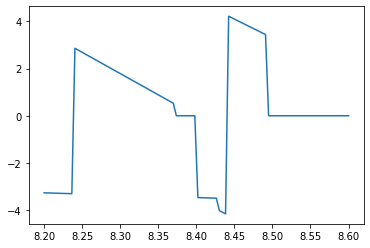

time taken 29.939327239990234


In [63]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time
from array import *

start = time.time()

cosp_init = 0.0    
N = 4
h = 25.0
h0 = 0.1
nn = 0   # this is the th column of the inital floquet evolution matrix 
         # for which the path we shall follow

q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(8.2,8.6,100)
omegas = omega_range


psi = np.eye(N) + (1j) * np.zeros((N,N))
cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(omegas))
prob = np.zeros(N)
title = "mf floquet dynamics: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)



if __name__ == '__main__':
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
    
    # calculate for first frequency
    w = omegas[0]
    T = 2 * np.pi/w                            
    t = np.linspace(0,2 * np.pi/w,N)           
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[N-1]
    
    #print('flomat',floqEvolution_mat)
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals[nn]))/T
    evecs_path = evecs[nn]/np.linalg.norm(evecs[nn])    # normalisation done
    phasefunc_path[0] = phasefunc
    
    # calculate for rest of the frequencies
    for cc, w in enumerate(omegas[1:len(omegas)]):
        T = 2 * np.pi/w                      
        t = np.linspace(0,2 * np.pi/w,N)    
        floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))        
        
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]       
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1] 
        evals, evecs = eig(floqEvolution_mat)
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs))) 
        #print('prob',prob)
        
        for i,pr in enumerate(prob):
            if (pr.real >= 0.9):
                pp = i
                #print('pp',pp)
                break
        evecs_path = evecs[pp]
        #print('evecs path',evecs_path)
        #print('evals[pp]',evals[pp])
        phasefunc = (1j * np.log(evals[pp]))/T
        phasefunc_path[cc+1] = phasefunc
    
    print('phaefunction path',phasefunc_path)
    plt.plot(omegas,phasefunc_path.real)
    plt.show()
    print('time taken',time.time()-start)

<ipython-input-19-e23d2bf38bf3>:101: ComplexWarning: Casting complex values to real discards the imaginary part
  phasefunc_path[0] = phasefunc
<ipython-input-19-e23d2bf38bf3>:126: ComplexWarning: Casting complex values to real discards the imaginary part
  phasefunc_path[cc+1] = phasefunc
<ipython-input-19-e23d2bf38bf3>:114: RuntimeWarning: divide by zero encountered in true_divide
  prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs)))
<ipython-input-19-e23d2bf38bf3>:114: RuntimeWarning: invalid value encountered in true_divide
  prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs)))
<ipython-input-19-e23d2bf38bf3>:125: RuntimeWarning: divide by zero encountered in log
  phasefunc = (1j * np.log(evals[pp]))/T
<ipython-input-19-e23d2bf38bf3>:125: RuntimeWarning: invalid value encountered in cdouble_scalars
  phasefunc = (1j * np.log(evals[pp]

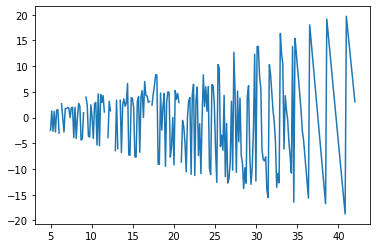

time taken 2046.4071884155273


In [19]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time
from array import *

start = time.time()

cosp_init = 0.0    
N = 20
h = 25.0
h0 = 0.1
nn = 1   # this is the th column of the inital floquet evolution matrix 
         # for which the path we shall follow

q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(6.5,6.8,20)
omegas = omega_range


psi = np.eye(N) + (1j) * np.zeros((N,N))
cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(omegas))
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N)
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

if __name__ == '__main__':
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
    
    # calculate for first frequency
    w = omegas[0]
    T = 2 * np.pi/w                            
    t = np.linspace(0,2 * np.pi/w,N)           
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[N-1]
    
    #print('flomat',floqEvolution_mat)
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals[nn]))/T
    evecs_path = evecs[nn]/np.linalg.norm(evecs[nn])    # normalisation done
    phasefunc_path[0] = phasefunc
    
    # calculate for rest of the frequencies
    for cc, w in enumerate(omegas[1:len(omegas)]):
        T = 2 * np.pi/w                      
        t = np.linspace(0,2 * np.pi/w,N)    
        floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))        
        
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]       
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1] 
        evals, evecs = eig(floqEvolution_mat)
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs))) 
        #print('prob',prob)
        
        for i,pr in enumerate(prob):
            if (pr.real >= 0.9999):
                pp = i
                #print('pp',pp)
                break
        evecs_path = evecs[pp]
        #print('evecs path',evecs_path)
        #print('evals[pp]',evals[pp])
        phasefunc = (1j * np.log(evals[pp]))/T
        phasefunc_path[cc+1] = phasefunc
    
    #print('phaefunction path',phasefunc_path)
    plt.figure(figsize = (14,7))
    plt.title(title)
    plt.xlabel("omega")
    plt.plot(omegas,phasefunc_path.real)
    plt.savefig(photoname,dpi = 500)
    plt.show()
    print('time taken',time.time()-start)

###  Mahbub's experiment

/home/mahi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


time taken 135.46568274497986


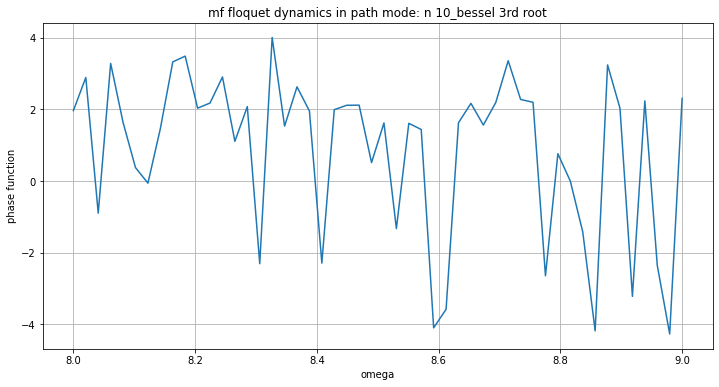

In [26]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time
from array import *

start = time.time()

cosp_init = 0.0    
N = 10
h = 25.0
h0 = 0.1
nn = 1   # this is the th column of the inital floquet evolution matrix 
         # for which the path we shall follow

q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(8.0,9.0,50)
omegas = omega_range


psi = np.eye(N) + (1j) * np.zeros((N,N))
cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
cosp_init = np.zeros((N,N)) + (1j) * np.zeros((N,N))
floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(omegas))
prob = np.zeros(N)
title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 3rd root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel3.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp), periodic_psi)

if __name__ == '__main__':
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
    
    # calculate for first frequency
    w = omegas[0]
    T = 2 * np.pi/w                            
    t = np.linspace(0,2 * np.pi/w,N)           
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[N-1]
    
    #print('flomat',floqEvolution_mat)
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals[nn]))/T
    evecs_path = evecs[nn]/np.linalg.norm(evecs[nn])    # normalisation done
    phasefunc_path[0] = phasefunc.real
    # calculate for rest of the frequencies
    for cc, w in enumerate(omegas[1:len(omegas)]):
        #print('evecs_path',evecs_path)
        T = 2 * np.pi/w                      
        t = np.linspace(0,2 * np.pi/w,N)    
        floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))        
        
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]       
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1] 
        evals, evecs = eig(floqEvolution_mat)
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path/np.linalg.norm(evecs_path)).T,x/np.linalg.norm(x)),evecs))) 
        #print('prob',prob.real)
        
        for i,pr in enumerate(prob):
            if (pr.real >= 0.9):
                pp = i
                #print('pp',pp)
                break
        evecs_path = evecs[pp]
        phasefunc = (1j * np.log(evals[pp]))/T
        phasefunc_path[cc+1] = phasefunc.real
    
    print('time taken',time.time()-start)
    #print('phaefunction path',phasefunc_path)
    plt.figure(figsize = (12,6))
    plt.title(title)
    plt.xlabel("omega")
    plt.ylabel("phase function")
    plt.plot((omegas),phasefunc_path)
    plt.grid()
    plt.savefig(photoname,dpi = 300)
    plt.show()  

In [11]:
np.dot(np.conjugate(evecs).T, evecs[0]/(np.linalg.norm(x)))

NameError: name 'x' is not defined

In [31]:
sig_x = np.array([[0,1],[1,0]])
print(np.dot(np.conjugate(sig_x).T,sig_x))

[[1 0]
 [0 1]]


In [ ]:
oo = np.array([[0.99999,0],[0,0.99999]])
ee = np.array([[1,0],[0,1]])
for i in np.arange(2):
    for j in np.arange(2):
        if (oo[i][j] == ee[i][j]):
            print('yes')
        else:
            print('no')

In [4]:
import numpy as np
a = np.arange(4)
b = np.linspace(5,8,4)
c = a * b
print(a)
print(b)
print(c)

[0 1 2 3]
[5. 6. 7. 8.]
[ 0.  6. 14. 24.]


In [19]:
aa = np.array([ 6.96855849e-01+4.32492111e-17j,  4.67907471e-01+2.12880144e-02j,
  4.88670197e-01+3.91497912e-02j, -9.73335274e-02+1.66872436e-01j,
  4.86965231e-02+6.90261656e-02j,  4.80674921e-02+5.29857239e-02j,
 -1.60803308e-02+4.74607410e-02j, -1.62624784e-02+4.81699862e-02j,
 -2.62596204e-05-5.86833086e-06j, -4.61515769e-05-1.81553716e-05j])
print(np.dot(np.conjugate(aa).T,aa))

(0.999999999866118+0j)
